# Multilayer perceptron - scikit implementation

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV

from multiprocessing import Pool
from pathlib import Path

## Importing the dataset

In [2]:
dataset = pd.read_csv('../../../Input_data/ML_SSM_dataset_v1_20220317/ML_training&testing_v01shuffled_20220317.csv')
dataset.head()

,Year,DOY,EVI,Evapo,LST_Daily,LST_Diff,NDVI,TI,T_air,API,Clay,Elevation,lat,lon,OMC,Porosity,Sand,Silt,Preci,Soil Moisture
0,2015,222,0.120117,-0.002280,29.12,31.14,0.183740,11.589293,23.996123,8.695007,19.700001,1752.627563,40.078119,-112.361396,3.56868,0.490566,37.700001,42.700001,0.000853,0.092000
1,2010,177,0.515586,-0.004072,19.55,8.68,0.685505,14.058996,21.684099,14.624732,22.799999,153.939468,48.726702,3.203102,6.65464,0.509434,10.400000,66.800003,0.000849,0.001500
2,2012,79,0.238310,-0.002077,8.04,10.50,0.410580,14.444198,8.660008,4.510628,23.799999,73.877228,43.717169,3.857831,6.98220,0.490566,29.799999,46.400002,0.321031,0.123435
3,2013,95,0.188224,-0.002522,12.32,29.50,0.352700,15.731341,7.477071,13.977669,31.600000,213.627564,40.052801,-88.372904,6.39604,0.471698,8.800000,59.599998,0.000435,0.394130
4,2007,299,0.435490,-0.001802,8.66,7.38,0.882154,12.428805,7.207212,52.144912,40.299999,192.723587,45.249999,-123.280000,16.34352,0.539623,15.800000,43.799999,0.001720,0.387500


## Construction of the matrix of characteristics (X) and the dependent variable vector (y)

In [3]:
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values

## Division of the dataset into the Training Set and the Test Set


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

## Very important: Feature scaling of X (z-transformation => mean = 0, std=1)

In [24]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [25]:
np.concatenate((X_train, X_test)).std(), np.concatenate((X_train, X_test)).mean()

(1.0007917647030506, -3.9066559978927426e-05)

# STEP 1: number of layers and number of neurons per layer

spoiler: 2 layers, 30 neurons each

## Creating regressors

1 - 2 - 3 layers, max 19^4 neurons [according to the rule]

In [162]:
regressors = []
n_layers = 1  

# 1 layer => 11 minutes
# 2 layers => 30 minutes
# 3 layers => 40 minutes
# 4 layers => 1h15m

neurons = [1, 5, 10, 15, 19, 25, 30, 19*2, 19*3, 19*4]

for i in neurons:
    print(i)

    regressor_i = MLPRegressor(hidden_layer_sizes=(i, i, i, i), 
                             activation = 'relu', #["identity", "logistic", "tanh", "relu"], 
                             solver = 'adam', #["lbfgs", "sgd", "adam"], 
                             learning_rate = 'constant', #['adaptive', 'invscaling', 'constant'],
                             max_iter=3000, early_stopping=True, tol=1e-6
                            ) 
    # regressor.fit(X_train, y_train)
    
    regressors.append(regressor_i)

1
5
10
15
19
25
30
38
57
76


## Training in parallel

In [163]:
%%time
def train_pool(regressor, X_train=X_train, y=y_train, X_test=X_test, y_test=y_test):
    regressor.fit(X_train, y_train)
    
    y_pred = regressor.predict(X_test)

    metrics_i = {
        'r2': r2_score(y_test, y_pred),
        'MAE': mean_absolute_error(y_test, y_pred),
        'MSE': mean_squared_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'r': np.corrcoef(y_test, y_pred)[0, 1]
    }
    
    return regressor, metrics_i

with Pool(len(regressors)) as p:
    res = p.map(train_pool, regressors)

CPU times: user 0 ns, sys: 778 ms, total: 778 ms
Wall time: 1h 13min 15s


In [6]:
# with open('EP/MLP/layer4.pkl', 'wb') as f:
#     pickle.dump(res, f)  # grid_search regressor

## Loading all trained

In [166]:
layers = {}
for layer in [1, 2, 3, 4]:
    with open(f'../../EP/MLP/layer{layer}.pkl', 'rb') as f:
        res = pickle.load(f)
    layers[f'layer{layer}'] = res

In [ ]:
dataset_val = pd.read_csv('../../../Input_data/ML_SSM_dataset_v1_20220317/ML_validating_v01_20220303.csv')
dataset2=pd.to_datetime(dataset_val['Date']) #move the datetime column to a new DF, and convert it to a recognized panda type 
DOY=dataset2.dt.dayofyear #create a Series "day", where the day of the year is stored
#also allows for weekofyear
Year= dataset2.dt.year #create a "year series"
dataset_val.insert(0, 'DOY', DOY) #insert the day series to the beggining of the dataset
dataset_val.insert(0, 'Year', Year)#insert the year series to the beggining of the dataset
dataset_val.drop(labels=['Date'], axis=1,inplace = True) #eliminate the date column
Xy = dataset_val[dataset.columns]
Xy.shape
X = Xy.iloc[:, :-1].values #all columns, but the last
y_val = Xy.iloc[:, -1].values #only the last column
# sc = StandardScaler()
# X_val = sc.fit_transform(X)
X_val = sc.transform(X)

In [179]:
def get_val_metrics(regressor, X_val=X_val, y_val=y_val):
        
    y_val_pred = regressor.predict(X_val)

    metrics_i = {
        'r2': r2_score(y_val, y_val_pred),
        'MAE': mean_absolute_error(y_val, y_val_pred),
        'MSE': mean_squared_error(y_val, y_val_pred),
        'RMSE': np.sqrt(mean_squared_error(y_val, y_val_pred)),
        'r': np.corrcoef(y_val, y_val_pred)[0, 1]
    }
    
    return metrics_i

In [180]:
metrics_val = {}
for k, res in layers.items():
    reg_res = []
    for reg_i, _ in res:
        reg_res.append((reg_i, get_val_metrics(reg_i)))
    metrics_val[k] = reg_res

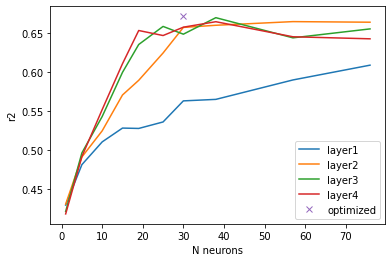

In [213]:
var = ['r2', 'MAE', 'MSE', 'RMSE', 'r']
var = 'r2'

for k, res in metrics_val.items():
    plt.plot(neurons, [x[1][var] for x in res])
    # plt.plot(neurons, [x[0].loss_ for x in res])
plt.legend(layers.keys())
plt.xlabel('N neurons')
plt.ylabel(var)
# plt.plot(30, r2score, 'x')  # optimized will be available after step 2
plt.legend(list(layers.keys()) + ['optimized'])

# STEP 2: fitting (30, 30) for other hyperparameters

In [205]:
# expected fit 21h (2 min * 648) in fact run 30 minutes
parameters = {  # the last is the default
    "activation": ["identity", "logistic", "tanh", "relu"], 
    # "solver": ["lbfgs", "sgd", "adam"],   # other than adam never finish
    "learning_rate": ['adaptive', 'invscaling', 'constant'],
    "tol": 10.0 ** -np.arange(4, 8),
    "alpha": 10.0 ** -np.arange(4, 7),
    "early_stopping": [True, False]
}

In [201]:
parameters

{'activation': ['identity', 'logistic', 'tanh', 'relu'],
 'learning_rate': ['adaptive', 'invscaling', 'constant'],
 'tol': array([1.e-04, 1.e-05, 1.e-06, 1.e-07]),
 'alpha': array([1.e+00, 1.e-01, 1.e-02, 1.e-03, 1.e-04, 1.e-05]),
 'early_stopping': [True, False]}

# CV gridsearch

In [207]:
%%time

regressor = MLPRegressor(random_state=0, 
                         max_iter=1000, 
                         solver='adam',
                         hidden_layer_sizes=(30, 30)
                        )

grid_search = GridSearchCV(estimator = regressor,
                           param_grid = parameters,
                           scoring = 'r2', #'accuracy',for classification only
                           verbose=True,
                           cv = 2,
                           n_jobs = 20)  # or -1 to use all CPUs

grid_search.fit(X_train, y_train)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_
print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:", best_parameters)

Fitting 2 folds for each of 288 candidates, totalling 576 fits
Best Accuracy: 75.45 %
Best Parameters: {'activation': 'tanh', 'alpha': 1e-06, 'early_stopping': False, 'learning_rate': 'adaptive', 'tol': 1e-07}
CPU times: user 9min 7s, sys: 1.88 s, total: 9min 9s
Wall time: 1h 27min 24s


In [2]:
# with open('EP/MLP/grid_search_30_30.pkl', 'wb') as f:
#     pickle.dump(grid_search, f)  # grid_search regressor

In [77]:
# with open('EP/MLP/grid_search_30_30.pkl', 'rb') as f:
#     loaded_model = pickle.load(f)
# loaded_model.score(X_test, y_test)